In [1]:
import pandas as pd
import re

data = """
среда, 26 мар. · 15:53 
status: Alerting. alertname: DatasourceNoData. 
status: Alerting. alertname: ПК PTI - Отказы по СЗ на этапе ПДН. summary: !ВРЕМЕННЫЙ АЛЕРТ! Отказ по проверке СЗ по Рефину на этапе ПДН. valueString: var='B0' metric='Value' labels={refuseCode=086} value=1. 
status: Alerting. alertname: Пример с errorCode. summary: Ошибка от OKI. valueString: var='D0' metric='Value' labels={errorCode=SYSTEM-OKI-009, hostname=pvlod-host01, app=TestApp} value=42. 
среда, 26 мар. · 19:41
"""

# Укажите путь к вашему файлу
file_path = '1804.txt'

# Чтение данных из файла
with open(file_path, 'r', encoding='utf-8') as file:
    data = file.read()



In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from io import StringIO

In [13]:
!pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB ? eta -:--:--
   ------------ -------------------------- 92.2/294.9 kB 655.4 kB/s eta 0:00:01
   ------------ -------------------------- 92.2/294.9 kB 655.4 kB/s eta 0:00:01
   --------------- ---------------------- 122.9/294.9 kB 450.6 kB/s eta 0:00:01
   -------------------------- ----------- 204.8/294.9 kB 731.4 kB/s eta 0:00:01
   -------------------------- ----------- 204.8/294


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
data

" понедельник, 10 мар. · 15:03 \nstatus: Alerting. alertname: UKP_CP_decline. description: {metric_name: Other,metric_group: App}. summary: Превышено количество Отказов в процессе КП как норма в рамках контроля оферты. valueString: var='A0' metric='Value' labels={} value=11. \nstatus: Alerting. alertname: UKP_CP_decline. description: {metric_name: Other,metric_group: App}. summary: Превышено количество Отказов в процессе КП как норма в рамках контроля оферты. valueString: var='A0' metric='Value' labels={} value=11. \nstatus: OK. alertname: UKP_CP_decline. description: {metric_name: Other,metric_group: App}. summary: Превышено количество Отказов в процессе КП как норма в рамках контроля оферты. \nstatus: Alerting. alertname: UKP_CP_decline. description: {metric_name: Other,metric_group: App}. summary: Превышено количество Отказов в процессе КП как норма в рамках контроля оферты. valueString: var='A0' metric='Value' labels={} value=11. \nstatus: OK. alertname: UKP_CP_decline. description

In [12]:
#!pip install pandas

In [3]:
# Шаблон даты/времени
date_pattern = re.compile(r'(?P<weekday>\w+), (?P<date>\d{1,2} \w+)\. · (?P<time>\d{2}:\d{2})')

# Шаблон основной строки
alert_pattern = re.compile(
    r'status: (?P<status>\w+)\. '
    r'alertname: (?P<alertname>.+?)\.'
    r'(?: description: (?P<description>{.*?})\.)?'
    r'(?: summary: (?P<summary>.+?)\.)?'
    r'(?: valueString: (?P<valueString>.+?)\.)?'
)

# Шаблон для valueString
value_string_pattern = re.compile(
    r"labels=\{(?P<labels>.*?)\}.*?value=(?P<val>[\d\.]+)"
)

results = []
label_keys_set = set()  # собираем все возможные ключи из labels

current_weekday = current_date = current_time = None

parsed_rows = []




In [4]:
for line in data.strip().splitlines():
    line = line.strip()

    date_match = date_pattern.match(line)
    if date_match:
        current_weekday = date_match.group('weekday')
        current_date = date_match.group('date')
        current_time = date_match.group('time')
        continue

    alert_match = alert_pattern.search(line)
    if alert_match:
        row = {
            'weekday': current_weekday,
            'date': current_date,
            'time': current_time,
            'status': alert_match.group('status'),
            'alertname': alert_match.group('alertname'),
            'description': alert_match.group('description') or '',
            'summary': alert_match.group('summary') or '',
            'valueString': alert_match.group('valueString') or '',
            'value': '',
        }

        # обработка valueString
        val_match = value_string_pattern.search(row['valueString'])
        if val_match:
            row['value'] = val_match.group('val')
            label_str = val_match.group('labels')

            # парсим labels={key=value, key2=value2}
            label_pairs = re.findall(r'(\w+)=([^\s,}]+)', label_str)
            for k, v in label_pairs:
                row[k] = v
                label_keys_set.add(k)

        parsed_rows.append(row)

# создаём DataFrame
df = pd.DataFrame(parsed_rows)

# добавляем пропущенные столбцы, если какие-то labels не встретились в конкретной строке
for key in label_keys_set:
    if key not in df.columns:
        df[key] = ''

# финальная таблица

In [5]:
df.head()

,weekday,date,time,status,alertname,description,summary,valueString,value,errorCode,product,activityId,refuseCode,deployment
0,понедельник,10 мар,15:03,Alerting,UKP_CP_decline,"{metric_name: Other,metric_group: App}",Превышено количество Отказов в процессе КП как...,var='A0' metric='Value' labels={} value=11,11,NaN,NaN,NaN,NaN,NaN
1,понедельник,10 мар,15:03,Alerting,UKP_CP_decline,"{metric_name: Other,metric_group: App}",Превышено количество Отказов в процессе КП как...,var='A0' metric='Value' labels={} value=11,11,NaN,NaN,NaN,NaN,NaN
2,понедельник,10 мар,15:03,OK,UKP_CP_decline,"{metric_name: Other,metric_group: App}",Превышено количество Отказов в процессе КП как...,,,NaN,NaN,NaN,NaN,NaN
3,понедельник,10 мар,15:03,Alerting,UKP_CP_decline,"{metric_name: Other,metric_group: App}",Превышено количество Отказов в процессе КП как...,var='A0' metric='Value' labels={} value=11,11,NaN,NaN,NaN,NaN,NaN
4,понедельник,10 мар,15:03,OK,UKP_CP_decline,"{metric_name: Other,metric_group: App}",Превышено количество Отказов в процессе КП как...,,,NaN,NaN,NaN,NaN,NaN


In [6]:
# ✅ Конвертируем дату + время в datetime (добавим новый столбец)
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d %b %H:%M', errors='coerce')

# ✅ Создадим колонку "время суток"
def get_daypart(hour):
    if 0 <= hour < 6:
        return 'ночь'
    elif 6 <= hour < 12:
        return 'утро'
    elif 12 <= hour < 18:
        return 'день'
    else:
        return 'вечер'

df['hour'] = df['datetime'].dt.hour
df['daypart'] = df['hour'].apply(get_daypart)

# ✅ Частота по alertname
alertname_counts = df['alertname'].value_counts()

# ✅ Частота по errorCode
error_counts = df['errorCode'].value_counts()

# ✅ Частота по value
value_counts = df['value'].value_counts()

# ✅ Группировка по дням недели и alertname
weekday_alerts = df.groupby(['weekday', 'alertname']).size().reset_index(name='count')

# ✅ Группировка по времени суток и errorCode
daypart_errors = df.groupby(['daypart', 'errorCode']).size().reset_index(name='count')

# ✅ Группировка по времени суток и value
daypart_values = df.groupby(['daypart', 'value']).size().reset_index(name='count')



In [7]:
# Выводим топовые значения
print("🔔 ТОП-Alertname:")
print(alertname_counts.head())

print("\n⚠️ ТОП-errorCode:")
print(error_counts.head())

print("\n📈 ТОП-value:")
print(value_counts.head())

print("\n📅 Анализ по дням недели:")
print(weekday_alerts)

print("\n🕒 Анализ по времени суток (errorCode):")
print(daypart_errors)

print("\n🕒 Анализ по времени суток (value):")
print(daypart_values)

🔔 ТОП-Alertname:
alertname
DatasourceNoData                                     86
POS Обратный поток (1                                61
PPRB RPK OKI-067                                     57
PPRB Превышено количество ошибок расчета КП (ЕТВ)    54
ППРБ                                                 49
Name: count, dtype: int64

⚠️ ТОП-errorCode:
errorCode
SYSTEM-OKI-067    30
SYSTEM-OKI-009     7
Name: count, dtype: int64

📈 ТОП-value:
value
     534
2     31
3     11
0     10
1      7
Name: count, dtype: int64

📅 Анализ по дням недели:
        weekday                                        alertname  count
0   воскресенье                                 DatasourceNoData      7
1   воскресенье                                     POS в ошибке      2
2   воскресенье                         PPRB RPK_EKP_errors_tech     14
3   воскресенье                 PPRB RPK_EKP_reverse_flow_payout      7
4   воскресенье            PPRB Входящий поток по  POS за 10 мин      3
..          ...      

C:\Users\Professional\AppData\Local\Temp\ipykernel_10992\2231051946.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=alertname_counts.values, y=alertname_counts.index, palette='Blues_d')
C:\Users\Professional\AppData\Local\Temp\ipykernel_10992\2231051946.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_counts.values, y=error_counts.index, palette='Reds_d')
C:\Users\Professional\AppData\Local\Temp\ipykernel_10992\2231051946.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, pale

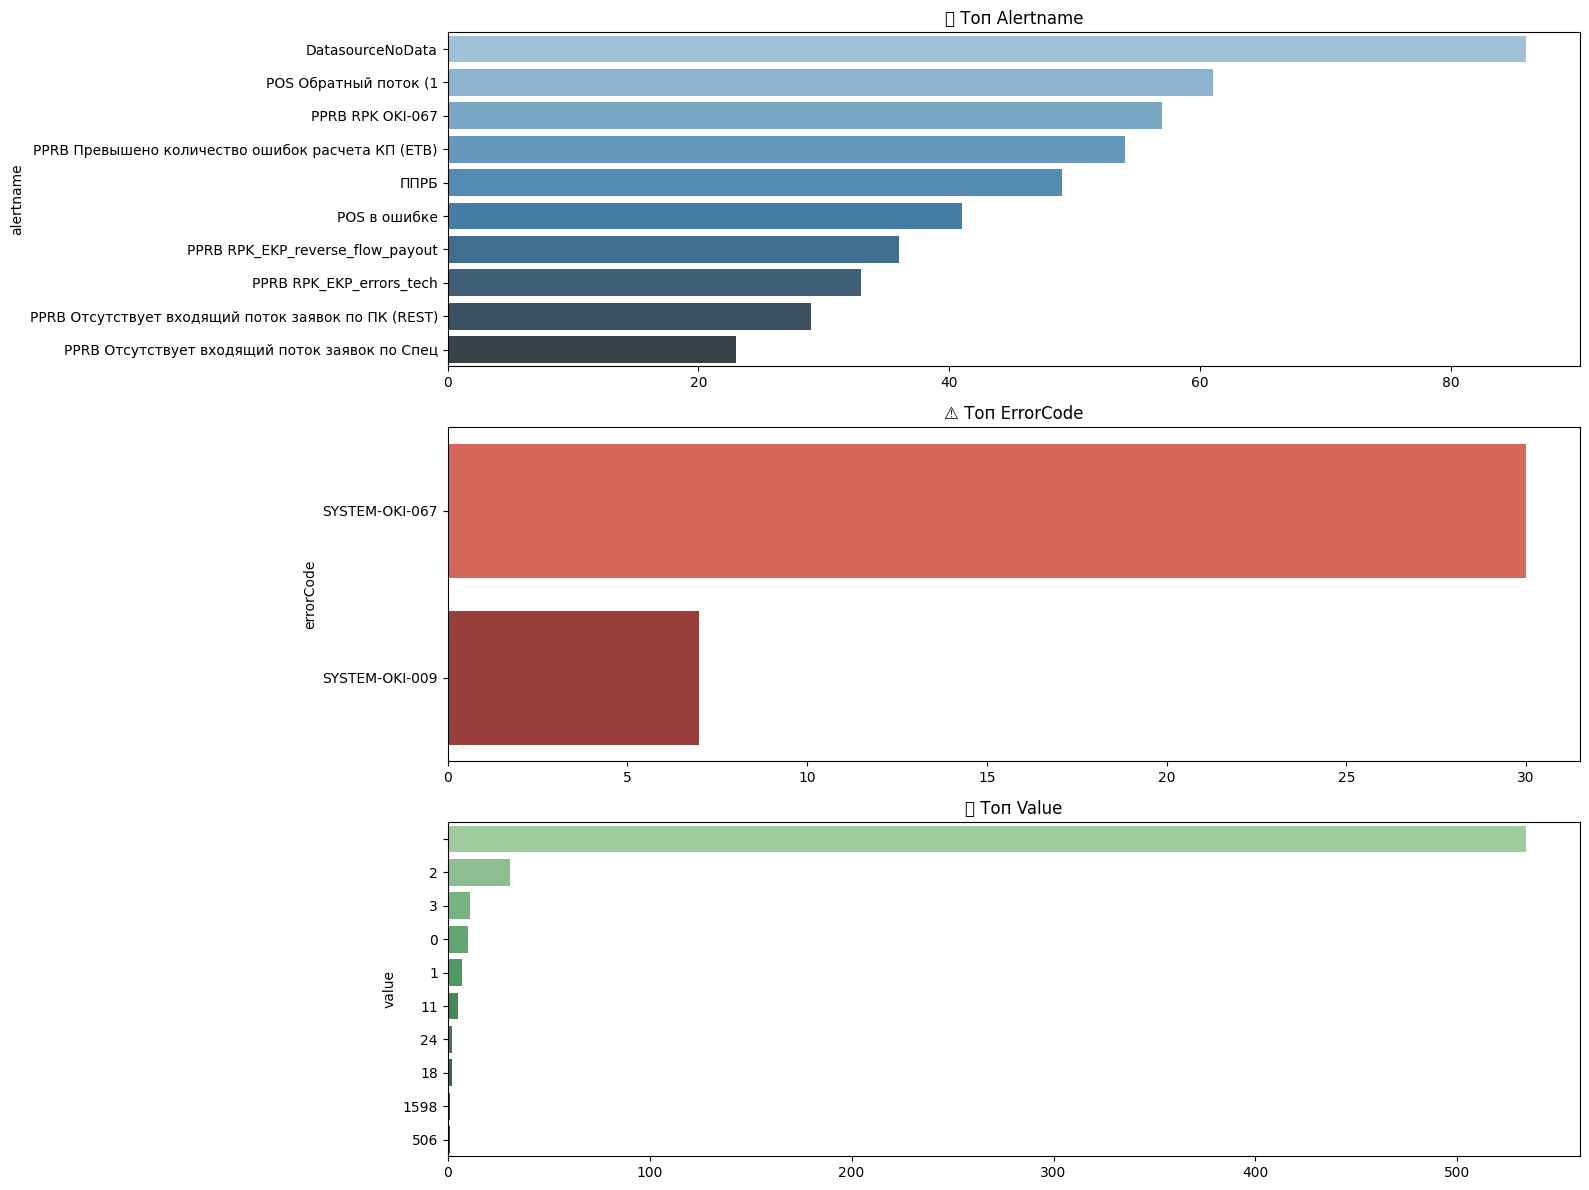

In [15]:
df['daypart'] = df['hour'].apply(get_daypart)

# Частоты
alertname_counts = df['alertname'].value_counts().head(10)
error_counts = df['errorCode'].value_counts().head(10)
value_counts = df['value'].value_counts().head(10)

# Визуализация
plt.figure(figsize=(16, 12))

# Alertname
plt.subplot(3, 1, 1)
sns.barplot(x=alertname_counts.values, y=alertname_counts.index, palette='Blues_d')
plt.title('🔔 Топ Alertname')

# ErrorCode
plt.subplot(3, 1, 2)
sns.barplot(x=error_counts.values, y=error_counts.index, palette='Reds_d')
plt.title('⚠️ Топ ErrorCode')

# Value
plt.subplot(3, 1, 3)
sns.barplot(x=value_counts.values, y=value_counts.index, palette='Greens_d')
plt.title('📈 Топ Value')

plt.tight_layout()
plt.show()

In [16]:
# Группировка по дням недели и alertname
weekday_alerts = df.groupby(['weekday', 'alertname']).size().reset_index(name='count')
weekday_pivot = weekday_alerts.pivot(index='alertname', columns='weekday', values='count').fillna(0)


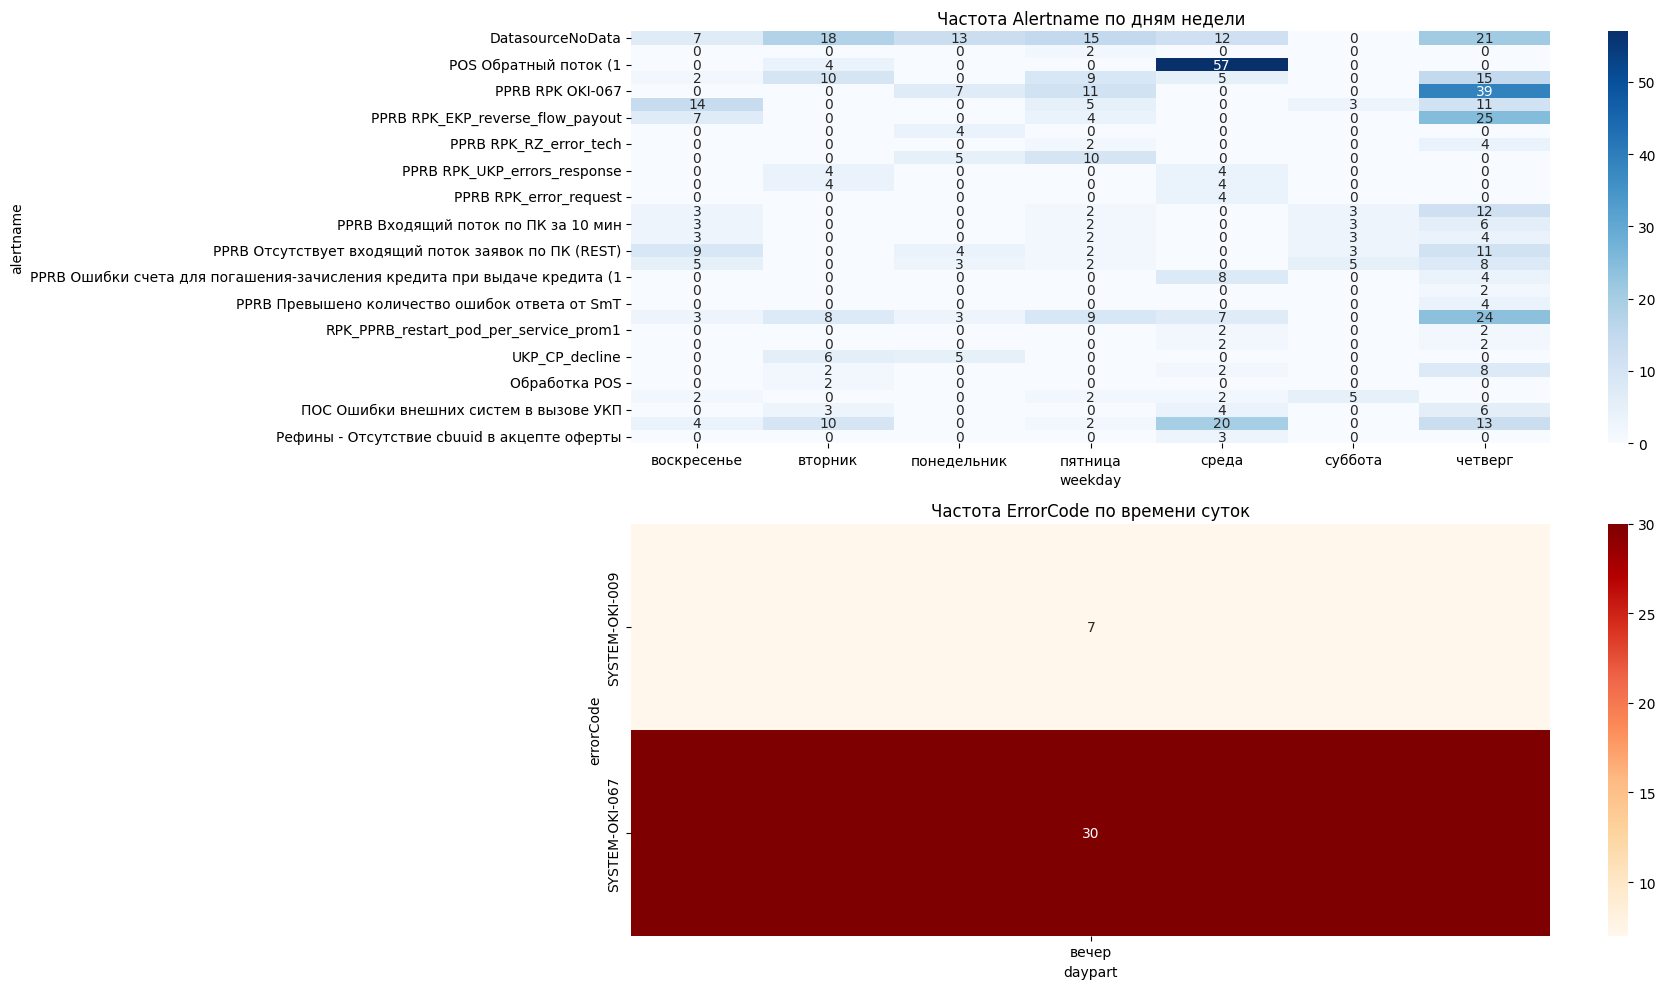

In [18]:
# Группировка по времени суток и errorCode
daypart_errors = df.groupby(['daypart', 'errorCode']).size().reset_index(name='count')
daypart_pivot = daypart_errors.pivot(index='errorCode', columns='daypart', values='count').fillna(0)

# Визуализация
plt.figure(figsize=(18, 10))
# Тепловая карта alertname по дням недели
plt.subplot(2, 1, 1)
sns.heatmap(weekday_pivot, annot=True, fmt='g', cmap='Blues')
plt.title('Частота Alertname по дням недели')

# Тепловая карта errorCode по времени суток
plt.subplot(2, 1, 2)
sns.heatmap(daypart_pivot, annot=True, fmt='g', cmap='OrRd')
plt.title('Частота ErrorCode по времени суток')

plt.tight_layout()
plt.show()